In [5]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import scipy
import datetime
import tqdm
from utils import *
import ast

import lightgbm as lgb
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k, auc_score
from lightfm.cross_validation import random_train_test_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Данные просмотров каналов**

In [7]:
df = pd.read_csv('dataset11-30.csv')
df.start_time = pd.to_datetime(df.start_time)
df.stop_time = pd.to_datetime(df.stop_time)

**Данные о тв-программе**

In [8]:
# данные из прошлого
df_info = pd.read_csv('export_arh_11-20-final.csv').append(pd.read_csv('export_arh_21-30-final.csv'))
df_info.start_time = pd.to_datetime(df_info.start_time, format='%d.%m.%Y %H:%M:%S')
df_info['stop_time'] = df_info['start_time'] + pd.to_timedelta(df_info['duration'], unit='s')
df_info = df_info[df_info.tv_show_id != 0].copy()

# данные на будущее
df_info_future = pd.read_csv('export_arh_31-42-final.csv', low_memory=False)
df_info_future.start_time = pd.to_datetime(df_info_future.start_time, format='%d.%m.%Y %H:%M:%S')
df_info_future['stop_time'] = df_info_future['start_time'] + pd.to_timedelta(df_info_future['duration'], unit='s')
df_info_future = df_info_future[df_info_future.tv_show_id != 0].copy()

# категориальные признаки
for c in ['tv_show_category', 'tv_show_genre_1', 'tv_show_genre_2', 'tv_show_genre_3']:
    df_info[c] = LabelEncoder().fit_transform(df_info[c].fillna('Nope'))

**Данные просмотров тв-программ**

In [9]:
df_show = pd.read_csv('dataset_with_shows.csv')
for c in ['start_time', 'show_start_time', 'stop_time','show_stop_time']:
    df_show[c] = pd.to_datetime(df_show[c])
df_show['start_show_user_time'] = df_show[['show_start_time','start_time']].max(axis=1)
df_show['stop_show_user_time'] = df_show[['stop_time','show_stop_time']].min(axis=1)
df_show['user_watch_time'] = (df_show['stop_show_user_time'] - df_show['start_show_user_time']).dt.total_seconds()
df_show['show_duration'] = (df_show['show_stop_time'] - df_show['show_start_time']).dt.total_seconds()
df_show['user_watch_perc'] = df_show['user_watch_time'] / df_show['show_duration']

**Кодирование user_id, tv_show_id для LightFM**

In [10]:
for c in ['user_id', 'tv_show_id']:
    _temp = df_show[[c]].drop_duplicates().reset_index(drop = True)
    _temp[f"cont_{c}"] = np.arange(_temp.shape[0])

    df_show = df_show.merge(_temp, on = [c], how = 'left')
    
user_col = 'cont_user_id'
movie_col = 'cont_tv_show_id'

_temp = df_show[['tv_show_id', movie_col]].drop_duplicates()
movies_dict = dict(zip(_temp[movie_col].values, _temp['tv_show_id'].values))

_temp = df_show[['user_id', user_col]].drop_duplicates()
users_dict = dict(zip(_temp[user_col].values, _temp['user_id'].values))

# Проверка точности решения на holdout выборке

**Split data to train / val**

In [11]:
train_start_date = df_show.start_time.min()
split_date = df_show.start_time.max() - datetime.timedelta(days = 9 * 7) # 9 weeks

train = df_show[(df_show.start_time <= split_date) & (df_show.start_time >= train_start_date)].copy()
df_info_train = df_info[(df_info.start_time <= split_date) & (df_info.start_time >= train_start_date)].copy()

val = df_show[df_show.start_time > split_date].copy()
df_info_val = df_info[df_info.start_time > split_date].copy()

# Запоминаем какие тв-программы могут быть в валидации
possible_movies_in_val = df_info_val.tv_show_id.unique()
print(train.shape, val.shape)

(2537448, 14) (1310248, 14)


**Train LightFm**

In [12]:
# sparse for lightfm
train_sparse = df_to_sparse_interaction_matrix(train)

# fit lightfm
model = LightFM(random_state=42, loss = 'warp')
model.fit(train_sparse, epochs=15, num_threads=4, verbose = False);

#collect user biases
user_bias_df = pd.DataFrame(model.user_biases, columns = ['user_bias_lfm'])
user_bias_df['user_id'] = list(sorted(train[user_col].unique()))
user_bias_df['user_id'] = user_bias_df['user_id'].apply(lambda x: users_dict.get(x))

#collect item biases
show_bias_df = pd.DataFrame(model.item_biases, columns = ['show_bias_lfm'])
show_bias_df['tv_show_id'] = list(sorted(train[movie_col].unique()))
show_bias_df['tv_show_id'] = show_bias_df['tv_show_id'].apply(lambda x: movies_dict.get(x))

# предскажем топ N актуальных программ для каждого пользователя из train
train_users = sorted(train[user_col].unique())

# можем прогнозировать только фильмы которые точно будут в таргете
train_movies = sorted(train[train['tv_show_id'].isin(possible_movies_in_val)][movie_col].unique())

get_n = 200
lightfm_predictions_df = pd.DataFrame()
for train_user in train_users:
    
    all_movies_df = pd.DataFrame(train_movies, columns = [movie_col])
    all_movies_df[user_col] = train_user
    all_movies_df['lightfm_score'] = model.predict(train_user, train_movies)
    all_movies_df.sort_values('lightfm_score', ascending = False, inplace = True)
    all_movies_df['lightfm_rank'] = np.arange(all_movies_df.shape[0])
    
    lightfm_predictions_df = lightfm_predictions_df.append(all_movies_df.head(get_n))
    
lightfm_predictions_df['user_id'] = lightfm_predictions_df[user_col].map(lambda x: users_dict.get(x))
lightfm_predictions_df['tv_show_id'] = lightfm_predictions_df[movie_col].map(lambda x: movies_dict.get(x))
lightfm_predictions_df.head(1)

,cont_tv_show_id,cont_user_id,lightfm_score,lightfm_rank,user_id,tv_show_id
19,20,0,-1.056485,0,7981779138282146703,2400480


**Выбор N фильмов для пользователя на основе просмотров и результатов LightFm**

In [13]:
get_n = 200
train_base = train[train['tv_show_id'].isin(possible_movies_in_val)].copy()
val_base = val.copy()
train = get_features(train_base, get_n)
val = get_target(val_base, get_n)
overal_val = get_target(val_base, 10000)
print(train.shape, val.shape)

(165997, 3) (120146, 3)


**Добавить LightFm как доп строки**

In [14]:
# если неполные рекомендации (пользователь смотрел < get_n) то добавим рекомендации из lightfm
train_w_lfm = train.copy()
for user, group in train.groupby(['user_id']):
    
    if group.shape[0] < get_n:
        
        need_to_add = get_n - group.shape[0]
        add_tv_show_ids_from_lightfm = lightfm_predictions_df[
            (lightfm_predictions_df.user_id == user)&
            (~lightfm_predictions_df.tv_show_id.isin(group.tv_show_id.unique()))]\
            .tv_show_id.values[:need_to_add]
        
        add_df = pd.DataFrame(add_tv_show_ids_from_lightfm, columns = ['tv_show_id'])
        add_df['user_id'] = user
        add_df['user_show_freq'] = 0
        add_df['user_id'] = add_df['user_id'].astype('uint64')
        
        train_w_lfm = train_w_lfm.append(add_df[['user_id', 'tv_show_id', 'user_show_freq']])
        
assert train.user_id.nunique() == train_w_lfm.user_id.nunique()
assert train_w_lfm.groupby(['user_id']).size().min() == get_n

train_w_lfm = train_w_lfm.merge(lightfm_predictions_df[['user_id', 'tv_show_id', 'lightfm_score']],
            on = ['user_id', 'tv_show_id'], how = 'left')

# combined train
train = train_w_lfm.copy()
train.reset_index(inplace = True, drop = True)

**Добавить таргет**

In [15]:
# create target from tv programs that user actually saw in the next 9 weeks
target_col = 'seen'
train = train.merge(overal_val.drop(['user_show_freq'], 1).assign(seen=1), on = ['user_id', 'tv_show_id'], how = 'left')
train[target_col].fillna(0, inplace = True)
print('Target distribution:')
train[target_col].value_counts()

Target distribution:


0.0    907107
1.0     50493
Name: seen, dtype: int64

**Добавить признаки**

In [16]:
# Удаляем тв-программы которые смотрело менее 10ти пользователей
shows_watches = train_base[train_base['user_watch_perc'] >= 0.8].groupby(['tv_show_id']).size().reset_index().rename(columns = {0:'show_watched'})
min_watch = 10
shows_watches = shows_watches[shows_watches['show_watched'] > min_watch].copy()
possible_movies_that_matter = shows_watches.tv_show_id.unique()
train = train[train.tv_show_id.isin(possible_movies_that_matter)].copy()
train.reset_index(inplace = True, drop = True)

In [17]:
# собираем признаки
train = prepare_features(train, df_info_train, df_info_val, train_base)
train = train.merge(user_bias_df, on = ['user_id'], how = 'left')
train = train.merge(show_bias_df, on = ['tv_show_id'], how = 'left')

**Валидация модели**

In [18]:
cat_columns = ['tv_show_category', 'tv_show_genre_1', 'tv_show_genre_2', 'tv_show_genre_3']
users_train, users_test = train_test_split(train.user_id.unique(), random_state = 42)

X_train = train[train.user_id.isin(users_train)].copy()
X_test = train[train.user_id.isin(users_test)].copy()
y_train = X_train.pop(target_col)
y_test = X_test.pop(target_col)

X_train = X_train.set_index(["user_id", "tv_show_id"])
X_test = X_test.set_index(["user_id", "tv_show_id"])
print(X_train.shape, X_test.shape)
print('Features:', list(X_train.columns))

(674755, 28) (224704, 28)
Features: ['user_show_freq', 'lightfm_score', 'user_show_rank', 'user_lfm_rank', 'combined_rank', 'channel_id', 'tv_show_category', 'tv_show_genre_1', 'tv_show_genre_2', 'tv_show_genre_3', 'user_show_freq_0.3', 'user_show_freq_0.8', 'alt_user_show_freq_0.3', 'alt_user_show_freq_0.5', 'alt_user_show_freq_0.8', 'user_show_freq_dif_week_1', 'user_show_rank_week_1', 'user_show_rank_mean_week_1', 'alt_user_show_freq_dif_week_1', 'alt_user_show_rank_mean_week_1', 'user_channel_count', 'group_user_show_freq', 'user_show_freq_rel_group', 'tot_show_duration', 'tot_show_duration_future', 'popularity_drop', 'user_bias_lfm', 'show_bias_lfm']


In [20]:
train_data = lgb.Dataset(X_train, y_train)
test_data = lgb.Dataset(X_test, y_test)

param = {
    'task': 'train',
    'objective': 'binary', 
    'metric': 'auc',
    'bagging_fraction': 0.8, 
    'bagging_freq': 4, 
    'colsample_bytree': '0.6', 
    'feature_fraction': 0.75, 
    'learning_rate': 0.01,
    'metric': 'auc',
    'min_data_in_leaf': 20, 
    'num_leaves': 150, 
    'num_threads': 4,
    'reg_alpha': 0.4,
    'reg_lambda': 0.32, 
    'seed': 42,
}

res = {}
bst = lgb.train(
    param, train_data, 
    valid_sets=[train_data, test_data], 
    valid_names=["train", "valid"],
    categorical_feature = cat_columns,
    num_boost_round=10000, evals_result=res, 
    verbose_eval=100, early_stopping_rounds=15)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['tv_show_category', 'tv_show_genre_1', 'tv_show_genre_2', 'tv_show_genre_3']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 15 rounds
[100]	train's auc: 0.898364	valid's auc: 0.89204
[200]	train's auc: 0.90727	valid's auc: 0.897362
[300]	train's auc: 0.913842	valid's auc: 0.900626
[400]	train's auc: 0.918984	valid's auc: 0.902516
[500]	train's auc: 0.923415	valid's auc: 0.903653
[600]	train's auc: 0.927714	valid's auc: 0.904065
Early stopping, best iteration is:
[588]	train's auc: 0.927074	valid's auc: 0.904125


In [21]:
X_test["lgb_score"] = bst.predict(X_test, num_iteration=bst.best_iteration)
lgb_res = X_test.reset_index([0, 1])[["user_id",
                                        "tv_show_id",
                                        "lgb_score"]].sort_values("lgb_score",
                                                                  ascending=False)

preds = []
trues = []
for user, group in lgb_res.groupby("user_id"):
    predict_n_movies = list(group.tv_show_id)[:5]
    actual_n_movies = val[val.user_id == user]['tv_show_id'].values[:5]
    
    preds.append(list(predict_n_movies))
    trues.append(list(actual_n_movies))
    
score = np.round(mapk(trues, preds, k = 5), 5)
print(f'Model MAP@{5} = {score}')

# reference (baseline)
preds = []
trues = []
for user, group in lgb_res.groupby("user_id"):
    predict_n_movies = train[train.user_id == user]['tv_show_id'].values[:5]
    actual_n_movies = val[val.user_id == user]['tv_show_id'].values[:5]
    
    preds.append(list(predict_n_movies))
    trues.append(list(actual_n_movies))
    
score = np.round(mapk(trues, preds, k = 5), 5)
print(f'Baseline MAP@{5} = {score}')

Model MAP@5 = 0.35318
Baseline MAP@5 = 0.31975


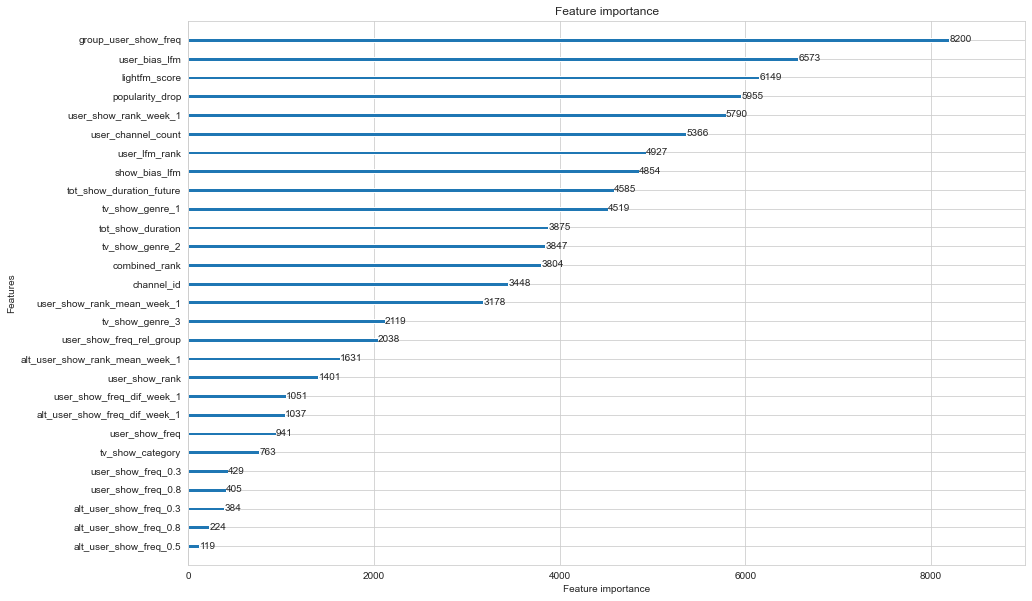

In [22]:
lgb.plot_importance(bst, figsize = (15, 10));

# Обучение финальной модели

In [23]:
# Full Train
X_train = train.copy()
y_train = X_train.pop(target_col)

X_train = X_train.set_index(["user_id", "tv_show_id"])
train_data = lgb.Dataset(X_train, y_train)

final_model = lgb.train(
    param, train_data, 
    categorical_feature = cat_columns,
    num_boost_round=bst.best_iteration+100, verbose_eval=False)

# final_model.save_model('tuned_.txt')

# Сбор финальных данных и прогноз submission

**Обновляем обученную Lightfm модель, теперь со всеми данными**

In [25]:
# sparse for lightfm
df_sparse = df_to_sparse_interaction_matrix(df_show)

# fit lightfm
lfm_final_model = LightFM(random_state=42, loss = 'warp')
lfm_final_model.fit(df_sparse, epochs=15, num_threads=4, verbose = False);

# предскажем топ N актуальных программ для каждого пользователя из train
train_users = sorted(df_show[user_col].unique())

# можем прогнозировать только фильмы которые точно будут в таргете
train_movies = sorted(df_show[df_show.tv_show_id.isin(df_info_future['tv_show_id'].unique())][movie_col].unique())

#collect user biases
df_user_bias_df = pd.DataFrame(lfm_final_model.user_biases, columns = ['user_bias_lfm'])
df_user_bias_df['user_id'] = list(sorted(df_show[user_col].unique()))
df_user_bias_df['user_id'] = df_user_bias_df['user_id'].apply(lambda x: users_dict.get(x))

#collect item biases
df_show_bias_df = pd.DataFrame(lfm_final_model.item_biases, columns = ['show_bias_lfm'])
df_show_bias_df['tv_show_id'] = list(sorted(df_show[movie_col].unique()))
df_show_bias_df['tv_show_id'] = df_show_bias_df['tv_show_id'].apply(lambda x: movies_dict.get(x))

# соберем рекомендации Lightfm для всех пользователей в трейне
get_n = 200
df_lightfm_predictions_df = pd.DataFrame()
for train_user in train_users:
    
    all_movies_df = pd.DataFrame(train_movies, columns = [movie_col])
    all_movies_df[user_col] = train_user
    all_movies_df['lightfm_score'] = lfm_final_model.predict(train_user, train_movies)
    all_movies_df.sort_values('lightfm_score', ascending = False, inplace = True)
    all_movies_df['lightfm_rank'] = np.arange(all_movies_df.shape[0])
    
    df_lightfm_predictions_df = df_lightfm_predictions_df.append(all_movies_df.head(get_n), sort = False)
    
df_lightfm_predictions_df['user_id'] = df_lightfm_predictions_df[user_col].map(lambda x: users_dict.get(x))
df_lightfm_predictions_df['tv_show_id'] = df_lightfm_predictions_df[movie_col].map(lambda x: movies_dict.get(x))
assert df_lightfm_predictions_df.user_id.nunique() == len(train_users)
df_lightfm_predictions_df.head(1)

,cont_tv_show_id,cont_user_id,lightfm_score,lightfm_rank,user_id,tv_show_id
20,20,0,-2.007087,0,7981779138282146703,2400480


**Собираем базовые признаки, обогащаем рекомендациями из LightFM**

In [27]:
# Базовые рекомендации - по топам просмотров
print(df_show.shape)
get_n = 200

possible_test_movies = df_info_future['tv_show_id'].unique()
df_show_base = df_show[df_show['tv_show_id'].isin(possible_test_movies)].copy()
df_show_train = get_features(df_show_base, get_n)
overall_top_movies = df_show_train.groupby(['tv_show_id'], as_index = False)['user_show_freq'].sum().sort_values(['user_show_freq'])['tv_show_id'][-5:].values[::-1]


(3847696, 14)


In [28]:
# если неполные рекомендации (пользователь смотрел < get_n) то добавим рекомендации из lightfm
df_train_w_lfm = df_show_train.copy()
for user, group in df_show_train.groupby(['user_id']):
    
    if group.shape[0] < get_n:
        
        need_to_add = get_n - group.shape[0]
        add_tv_show_ids_from_lightfm = df_lightfm_predictions_df[
            (df_lightfm_predictions_df.user_id == user)&
            (~df_lightfm_predictions_df.tv_show_id.isin(group.tv_show_id.unique()))]\
            .tv_show_id.values[:need_to_add]
        
        add_df = pd.DataFrame(add_tv_show_ids_from_lightfm, columns = ['tv_show_id'])
        add_df['user_id'] = user
        add_df['user_show_freq'] = 0
        add_df['user_id'] = add_df['user_id'].astype('uint64')
        
        df_train_w_lfm = df_train_w_lfm.append(add_df[['user_id', 'tv_show_id', 'user_show_freq']])
        
assert df_show_train.user_id.nunique() == df_train_w_lfm.user_id.nunique()
assert df_train_w_lfm.groupby(['user_id']).size().min() == get_n

df_train_w_lfm = df_train_w_lfm.merge(df_lightfm_predictions_df[['user_id', 'tv_show_id', 'lightfm_score']],
            on = ['user_id', 'tv_show_id'], how = 'left')

# combined train
df_show_train = df_train_w_lfm.copy()
df_show_train.reset_index(inplace = True, drop = True)

**Пост-обработка и добавление признаков**

In [29]:
# remove low-count movies
shows_watches = df_show_base[df_show_base['user_watch_perc'] >= 0.8].groupby(['tv_show_id']).size().reset_index().rename(columns = {0:'show_watched'})
min_watch = 10
shows_watches = shows_watches[shows_watches['show_watched'] > 10].copy()
possible_movies_that_matter = shows_watches.tv_show_id.unique()
df_show_train = df_show_train[df_show_train.tv_show_id.isin(possible_movies_that_matter)].copy()
df_show_train.reset_index(inplace = True, drop = True)

# collect features
df_show_train = prepare_features(df_show_train, df_info, df_info_future, df_show_base)
df_show_train = df_show_train.merge(df_user_bias_df, on = ['user_id'], how = 'left')
df_show_train = df_show_train.merge(df_show_bias_df, on = ['tv_show_id'], how = 'left')
print(df_show_train.shape)

(946344, 30)


**Предсказание submission**

In [31]:
# predict rank score
X_predict = df_show_train.copy()
X_predict = X_predict.set_index(["user_id", "tv_show_id"])[X_train.columns]
X_predict["lgb_score"] = final_model.predict(X_predict, num_iteration=bst.best_iteration)

In [32]:
pred_res = X_predict.reset_index([0, 1])[["user_id",
                                        "tv_show_id",
                                        "lgb_score"]].sort_values("lgb_score",
                                                                  ascending=False)

In [34]:
# create submission
submission_df = pd.read_csv('submission.csv')
for index_row, row in submission_df.iterrows():
    pred_n_movies = list(pred_res[pred_res.user_id == row['user_id']]['tv_show_id'].values[:5])
    
    if len(pred_n_movies) < 5:
        pred_n_movies = list(pred_n_movies[:len(pred_n_movies)]) + list(overall_top_movies[:5 - len(pred_n_movies)])
    
    pred = ' '.join([str(int(x)) for x in pred_n_movies])
    submission_df.loc[index_row, 'tv_show_id'] = pred
    
submission_df.to_csv('results/lfm_lgb6_submission.csv', index = False)
submission_df.head()

,user_id,tv_show_id
0,8377619604347126107,240081 2400480 2400508 20088 2400467
1,8381667675275833309,2400480 240081 6700482 12001682 2400467
2,8387147770138767246,12001682 12002856 12001732 12002355 12002955
3,8397181578236218580,240081 2400480 20088 2400467 6700482
4,8404698046253197367,2400480 240081 20088 200432 6200371
